In [67]:

# # Assessment 3 - Online Shoppers Purchasing Intention
# #### Objective: 

In [68]:


# data manipulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, accuracy_score, precision_score, recall_score, 
                             f1_score, matthews_corrcoef)

# dimensionality reduction
from sklearn.decomposition import PCA

# clustering
from sklearn.cluster import KMeans, DBSCAN

# data preprocessing
from sklearn.preprocessing import MinMaxScaler

# handling imbalanced data
from imblearn.over_sampling import SMOTE

# displaying outputs in jupyter
from IPython.display import display

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [69]:


# utility functions

def plotbox_and_hist(df, columns, figsize=(30, 80)):
    fig, axes = plt.subplots(len(columns), 2, figsize=figsize)

    for i, column in enumerate(columns):
        sns.boxplot(x=df[column], ax=axes[i, 0])
        sns.histplot(x=df[column], ax=axes[i, 1])

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

def countplot_value(df, columns, figsize=(20, 30)):
    # Compute the number of rows and columns for subplots
    num_columns = 2
    num_rows = (len(columns) + 1) // num_columns  # Ensures proper grid size for odd numbers
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, column in enumerate(columns):
        ax = axes[i]
        sns.countplot(x=df[column], ax=ax)
        
        # Annotate bar heights
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points')
        ax.set_title(f'{column} Counts')

    # Remove any unused subplot axes
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# ## 1. Retrieving and Preparing the Data

# ### 1.1. Data Loading

In [70]:


# load the dataset
file_path = 'online_shoppers_intention.csv'
df = pd.read_csv(file_path)


# ### 1.2. Dataset Observation

In [71]:


# display the first 5 rows of the dataset
display(df.head())

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

In [72]:


# summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [73]:


df.describe()


# ##### Analysis
# The dataset contains 12,330 rows and 18 columns. There are no missing values across any of the columns, as all 18 attributes have 12,330 non-null entries.
# 
# The data types are primarily integers and floats, with a few categorical variables (object types) like **Month** and **VisitorType**, as well as Boolean variables like **Weekend** and **Revenue**. The attributes can be categorized as follows:
# 
# - Categorical values: **Month**, **VisitorType**.
# - Numerical values:
#   - Discrete: **Administrative**, **Informational**, **ProductRelated**, **OperatingSystems**, **Browser**, **Region**, **TrafficType**.
#   - Continuous: **Administrative_Duration**, **Informational_Duration**, **ProductRelated_Duration**, **BounceRates**, **ExitRates**, **PageValues**, **SpecialDay**.
#   
# The **Revenue** column is a binary variable indicating whether a transaction resulted in revenue. The **Weekend** column is also Boolean, representing whether the visit occurred on the weekend.
# Further analysis can be conducted to explore relationships between these variables, especially the conversion-related columns like **Revenue**.

# ### 1.3. Detailed Analysis and Cleaning

Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        7.000000               184.137500   
50%                  0.000000       18.000000               598.936905   
75%                  0.000000       38.000000              1464.157214   
max               2549.375000      705.000000             63973.522230   

        BounceRates     ExitRates    PageValues    SpecialDay  \
count  12330.000000  12330.000000  12330.000000  12330.000000   
mean       0.022191      0.043073      5.889258      0.061427   
std        0.048488      0.048597     18.568437      0.198917   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.014286      0.000000      0.000000   
50%        0.003112      0.025156      0.000000      0.000000   
75%        0.016813      0.050000      0.000000      0.000000   
max        0.200000      0.200000    361.763742      1.000000   

       OperatingSystems       Browser        Region   TrafficType  
count      12330.000000  12330.000000  12330.000000  12330.000000  
mean           2.124006      2.357097      3.147364      4.069586  
std            0.911325      1.717277      2.401591      4.025169  
min            1.000000      1.000000      1.000000      1.000000  
25%            2.000000      2.000000      1.000000      2.000000  
50%            2.000000      2.000000      3.000000      2.000000  
75%            3.000000      2.000000      4.000000      4.000000  
max            8.000000     13.000000      9.000000     20.000000

In [74]:


# create a copy of the dataframe to store the cleaned data
df_clean = df.copy();

In [75]:


# display the unique values of the 'Month' and 'VisitorType' columns
print(df_clean['Month'].unique())
print(df_clean['VisitorType'].unique())

['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
['Returning_Visitor' 'New_Visitor' 'Other']


In [76]:


# fix typos in the 'Month' column
df_clean['Month'] = df_clean['Month'].replace({'June': 'Jun'})
# convert the 'Month' column to numerical values
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df_clean['Month'] = df_clean['Month'].map(month_map)
df_clean = df_clean.sort_values('Month')
# verify the changes
print(df_clean['Month'].unique())

[ 2  3  5  6  7  8  9 10 11 12]


In [77]:


# convert the 'Month' and 'Revenue' columns to numerical
bool_columns = ['Weekend', 'Revenue']
df_clean[bool_columns] = df_clean[bool_columns].astype(int)

# verify the conversion
df_clean.info()


# #### 1.3.1. Univariate Analysis of Numerical values

<class 'pandas.core.frame.DataFrame'>
Index: 12330 entries, 0 to 12303
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  int64  
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType              12

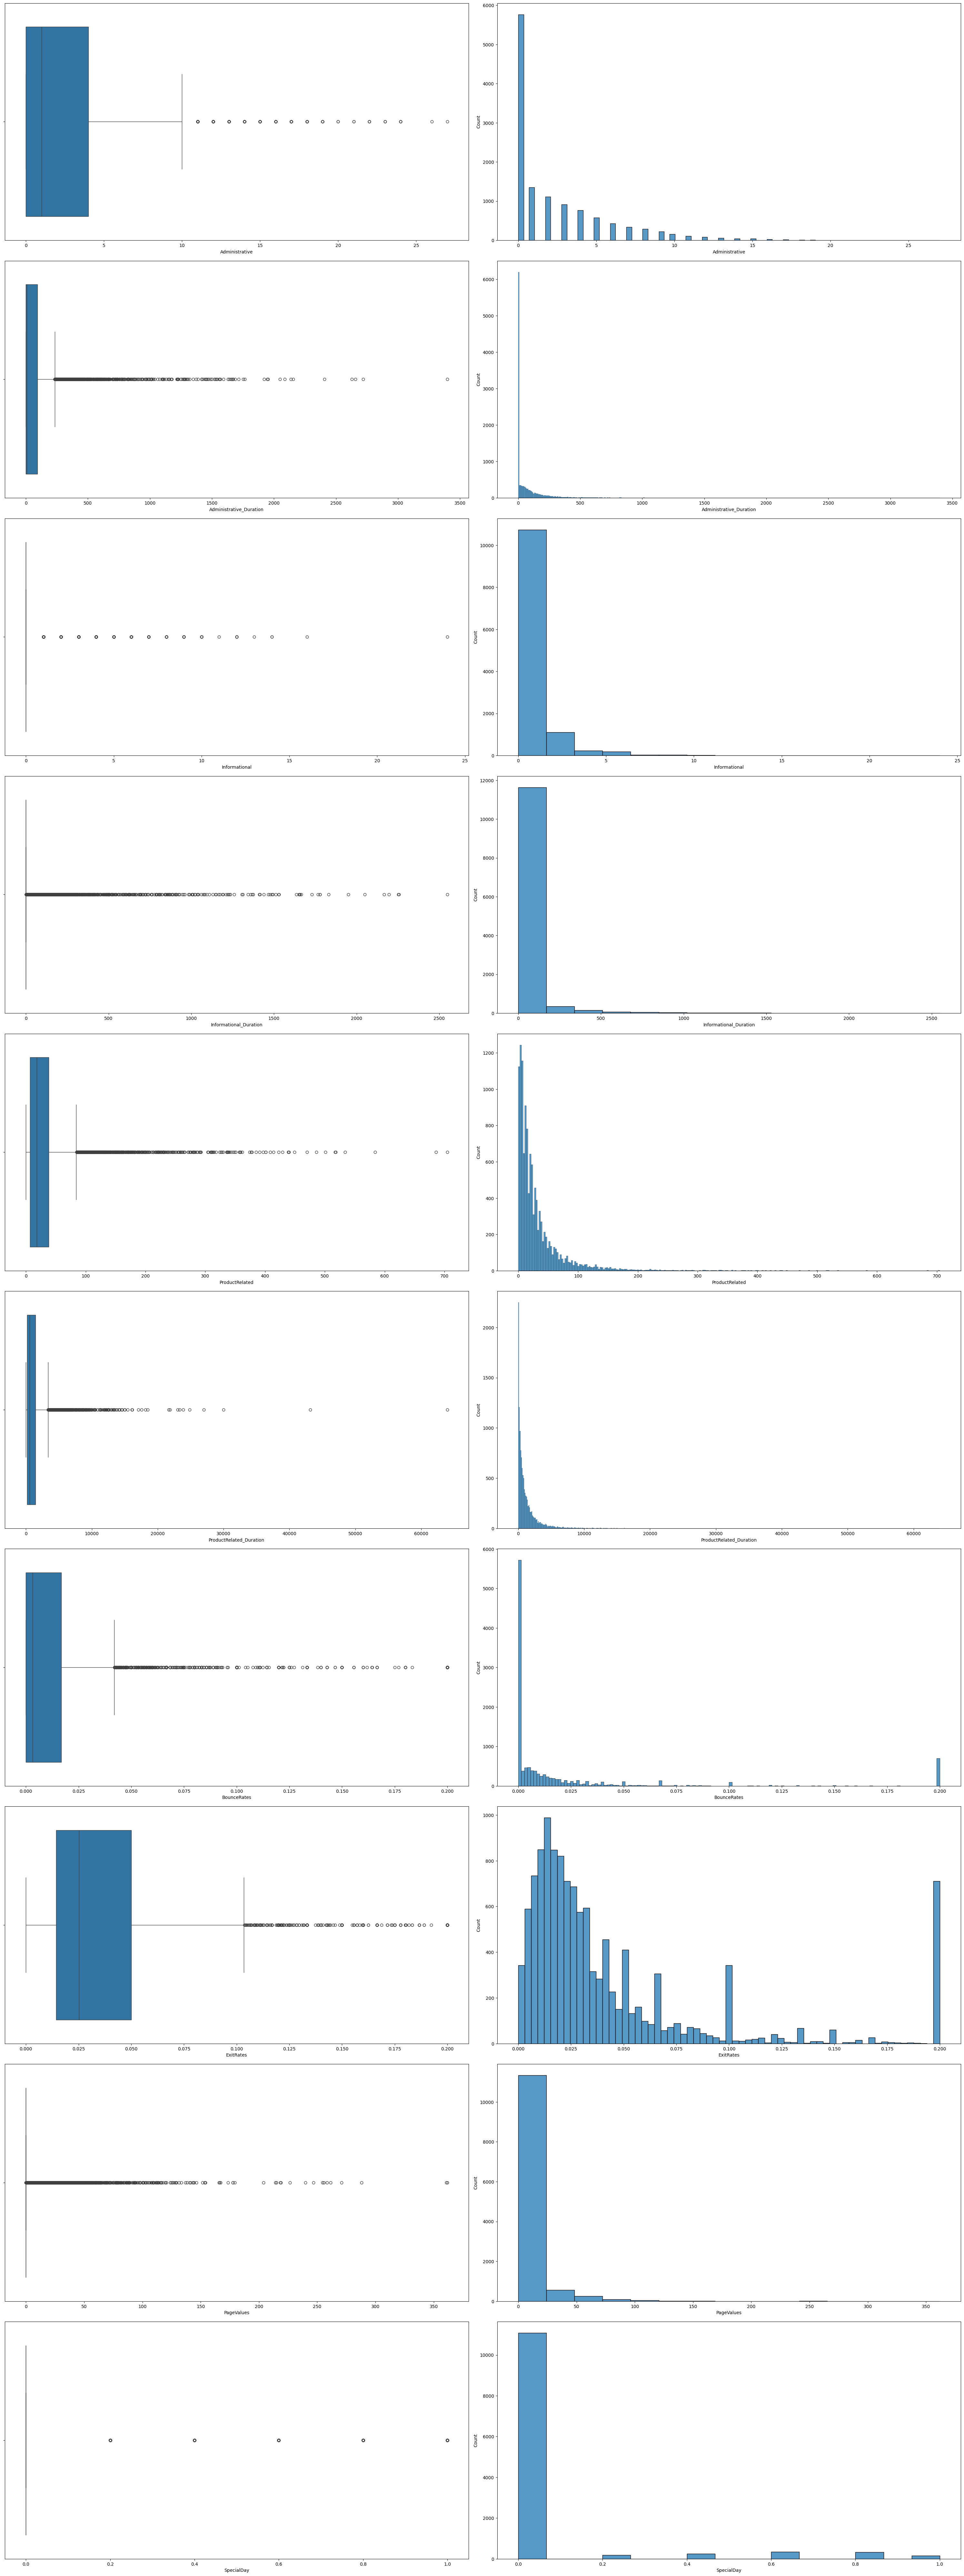

In [78]:


columns = ["Administrative", "Administrative_Duration", "Informational", "Informational_Duration",
           "ProductRelated", "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues",
           "SpecialDay"]

plotbox_and_hist(df_clean, columns)


# ##### Analysis
# - Histograms: Most features are right-skewed, with values concentrated on the lower end and long tails extending to higher values. Features like **Administrative** and **Administrative_Duration** show that most sessions involve minimal administrative activities, with outliers at higher values. **Informational** and **Informational_Duration** follow a similar pattern, suggesting that informational activities are not common in most sessions. **ProductRelated** and **ProductRelated_Duration** have a broader spread compared to administrative and informational features. This indicates more varied user engagement with product-related pages, although there are still some significant outliers. **BounceRates** and **ExitRates** are mostly near zero, showing that users usually stay on the site instead of leaving immediately. **PageValues** is skewed with most values being zero, while a few sessions have high values, showing only a small number of sessions generate significant revenue. **SpecialDay** has specific peaks that correspond to certain predefined special days in the data.
# 
# - Boxplots: Many features have visible outliers, represented by points beyond the whiskers of the boxplot. **Administrative_Duration** and **Informational_Duration** show tight interquartile ranges (IQRs) with outliers at higher values, confirming that most sessions have minimal durations for these activities. **ProductRelated_Duration** has a wider IQR, reflecting more variability in user interactions with product pages, but also includes a few extreme outliers. **BounceRates** and **ExitRates** have very narrow IQRs, with most values near zero, but occasional outliers suggest some sessions have high rates. **PageValues** has a compact IQR but includes extreme outliers, reflecting rare but impactful sessions with high page values. **SpecialDay** does not show significant outliers since its values are predefined and specific.
# 
# Further analysis will help us decide whether to clean datapoints, apply data imputation, or drop the problematic columns.

# #### 1.3.2. Univariate Analysis of Categorical values

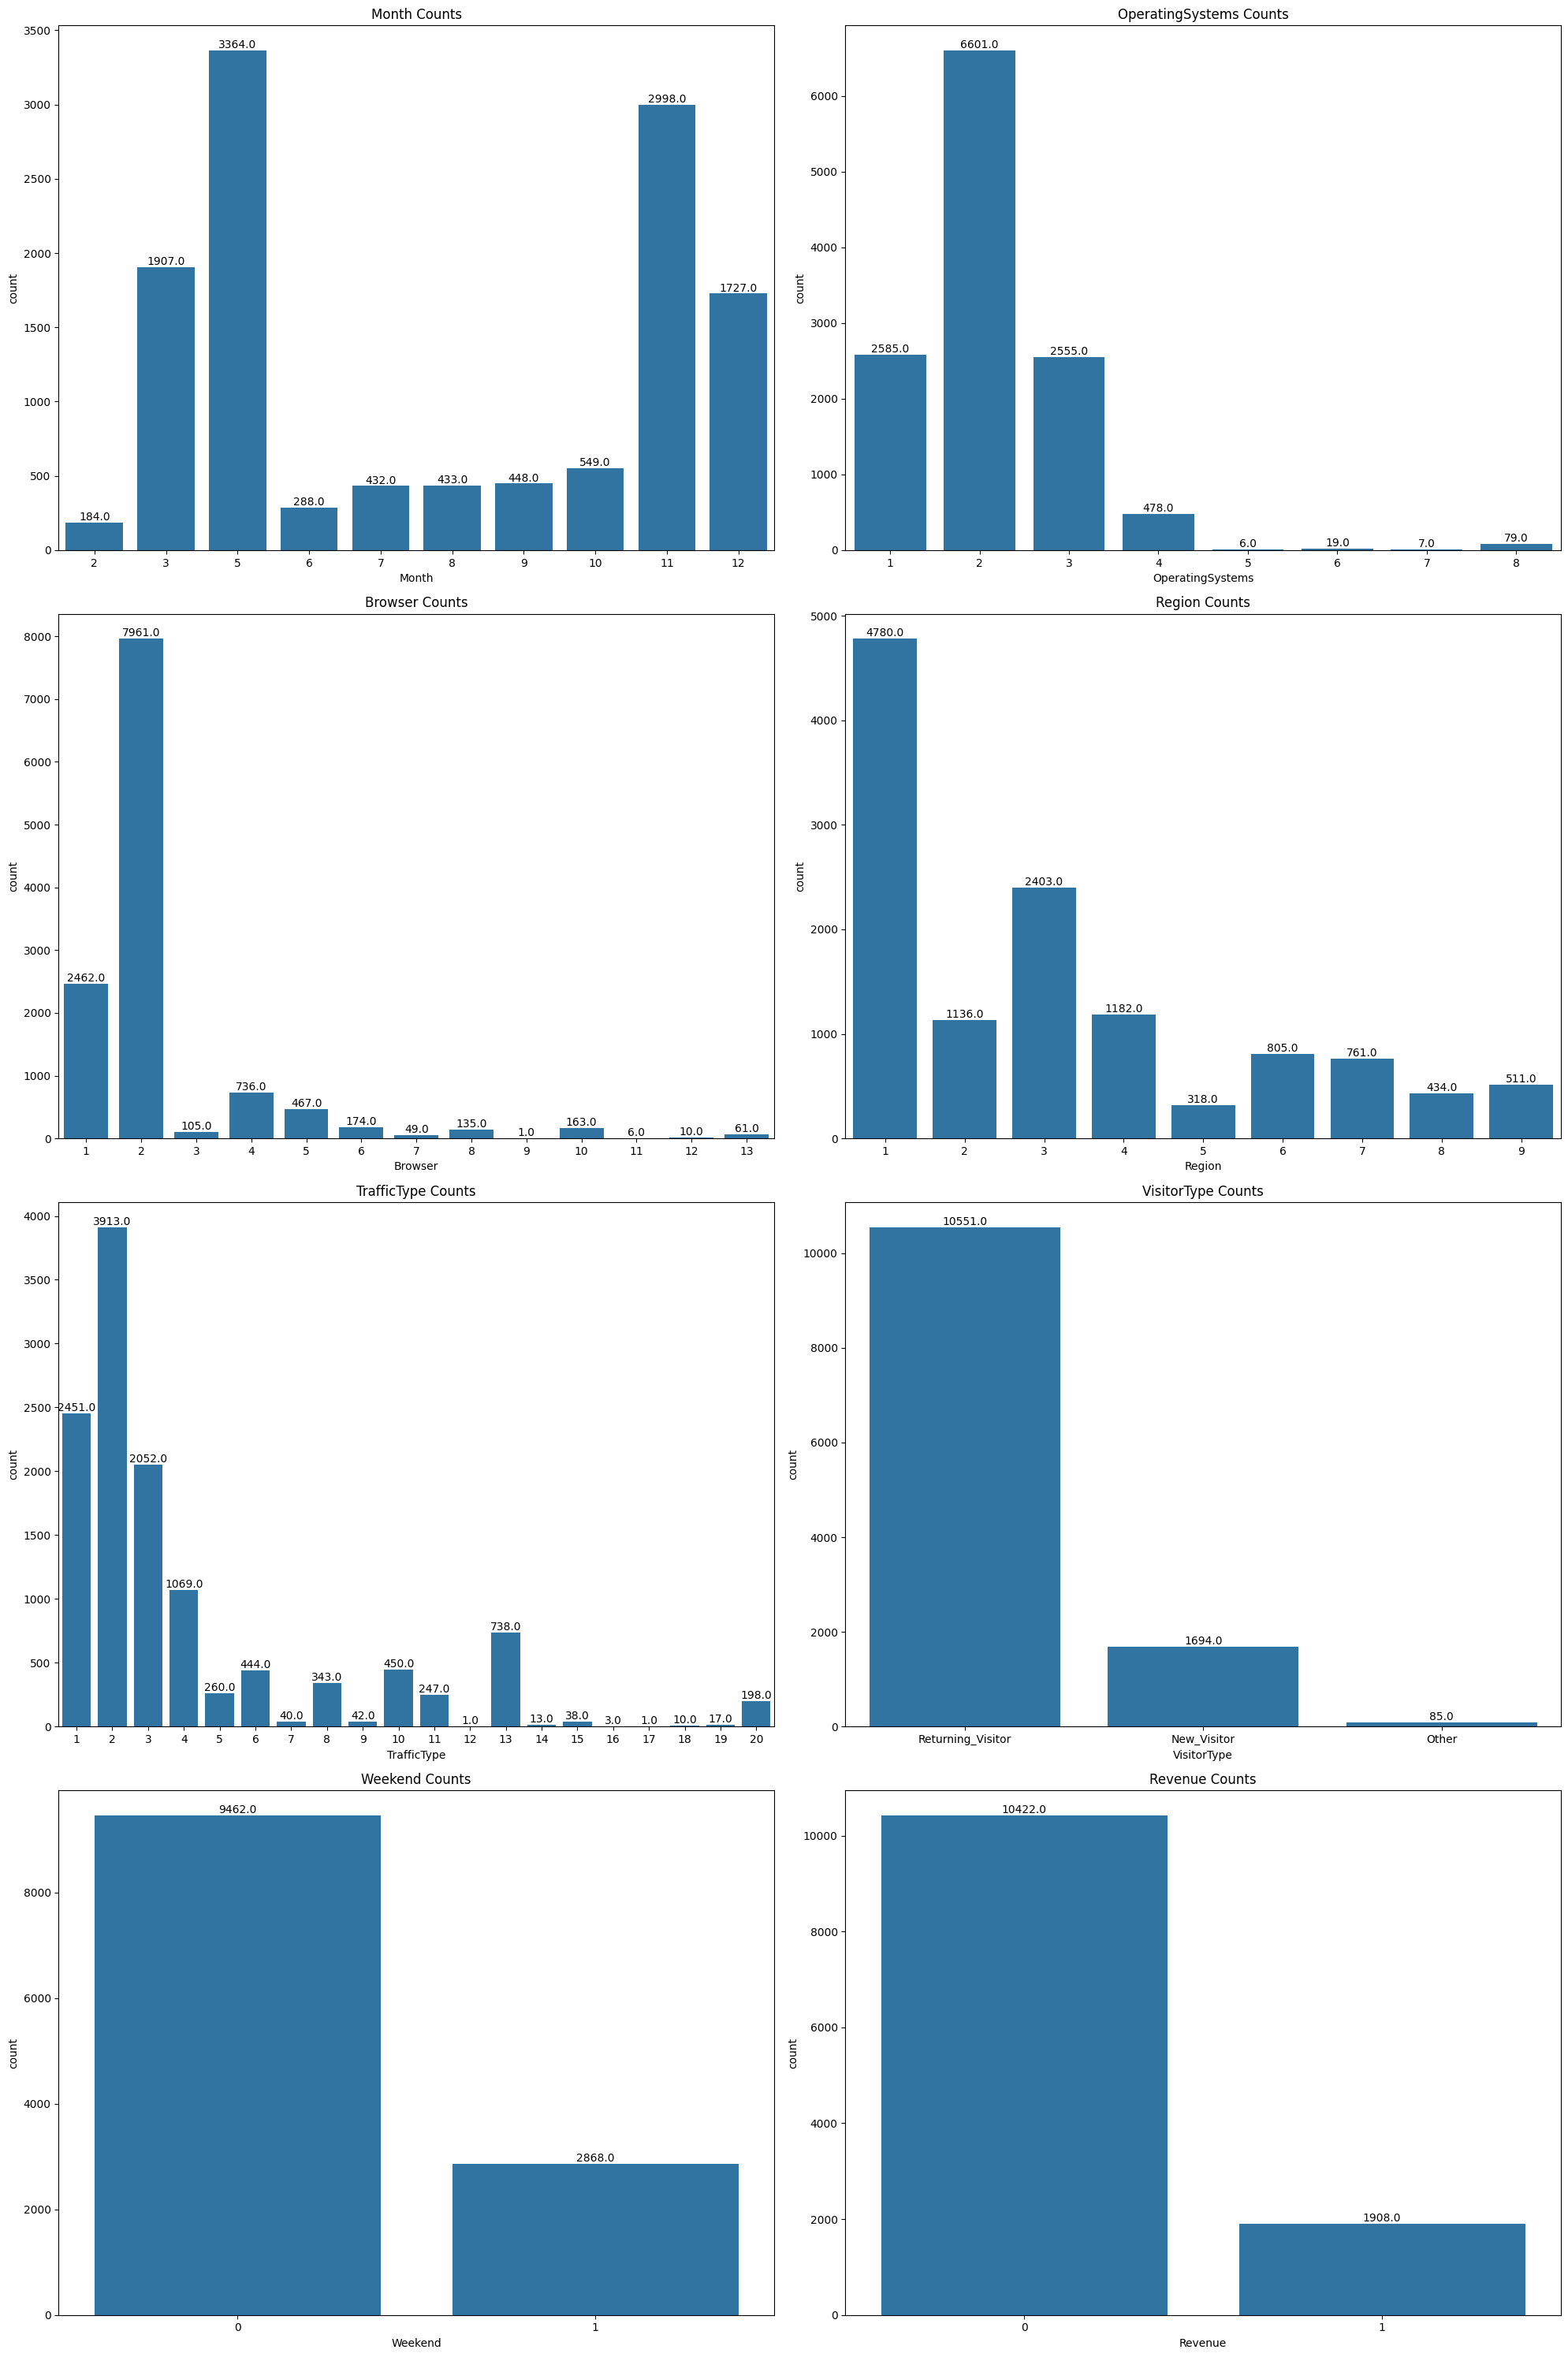

In [79]:


columns = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Revenue"]

countplot_value(df_clean, columns)


# ##### Analysis
# There are heavy imbalances across all categorical variables, specifically:
# - **Month**: March and November have the highest counts, while other months have significantly lower counts.
# - **OperatingSystems**: Operating systems 1, 2, and 3 dominate the data, while other systems have lower counts.
# - **Browser**: Browsers 1 and 2 have high counts, while other browsers show much lower counts.
# - **Region**: Regions 1 and 2 represent most of the data, with other regions showing significantly lower counts.
# - **TrafficType**: Traffic types 1 and 2 have higher counts, while other types are underrepresented.
# - **VisitorType**: Returning visitors are the most common, while new visitors and the 'other' category are less frequent.
# - **Weekend**: Non-weekend visits have the highest count, while weekend visits are much less frequent.
# - **Revenue**: Non-revenue generating visits dominate, while revenue-generating visits are much fewer.
# 
# Overall, imbalances could adversely affect the accuracy of predictions or analyses. Data imputation techniques might be considered to address this issue.

# #### 1.3.3. Multivariate Analysis

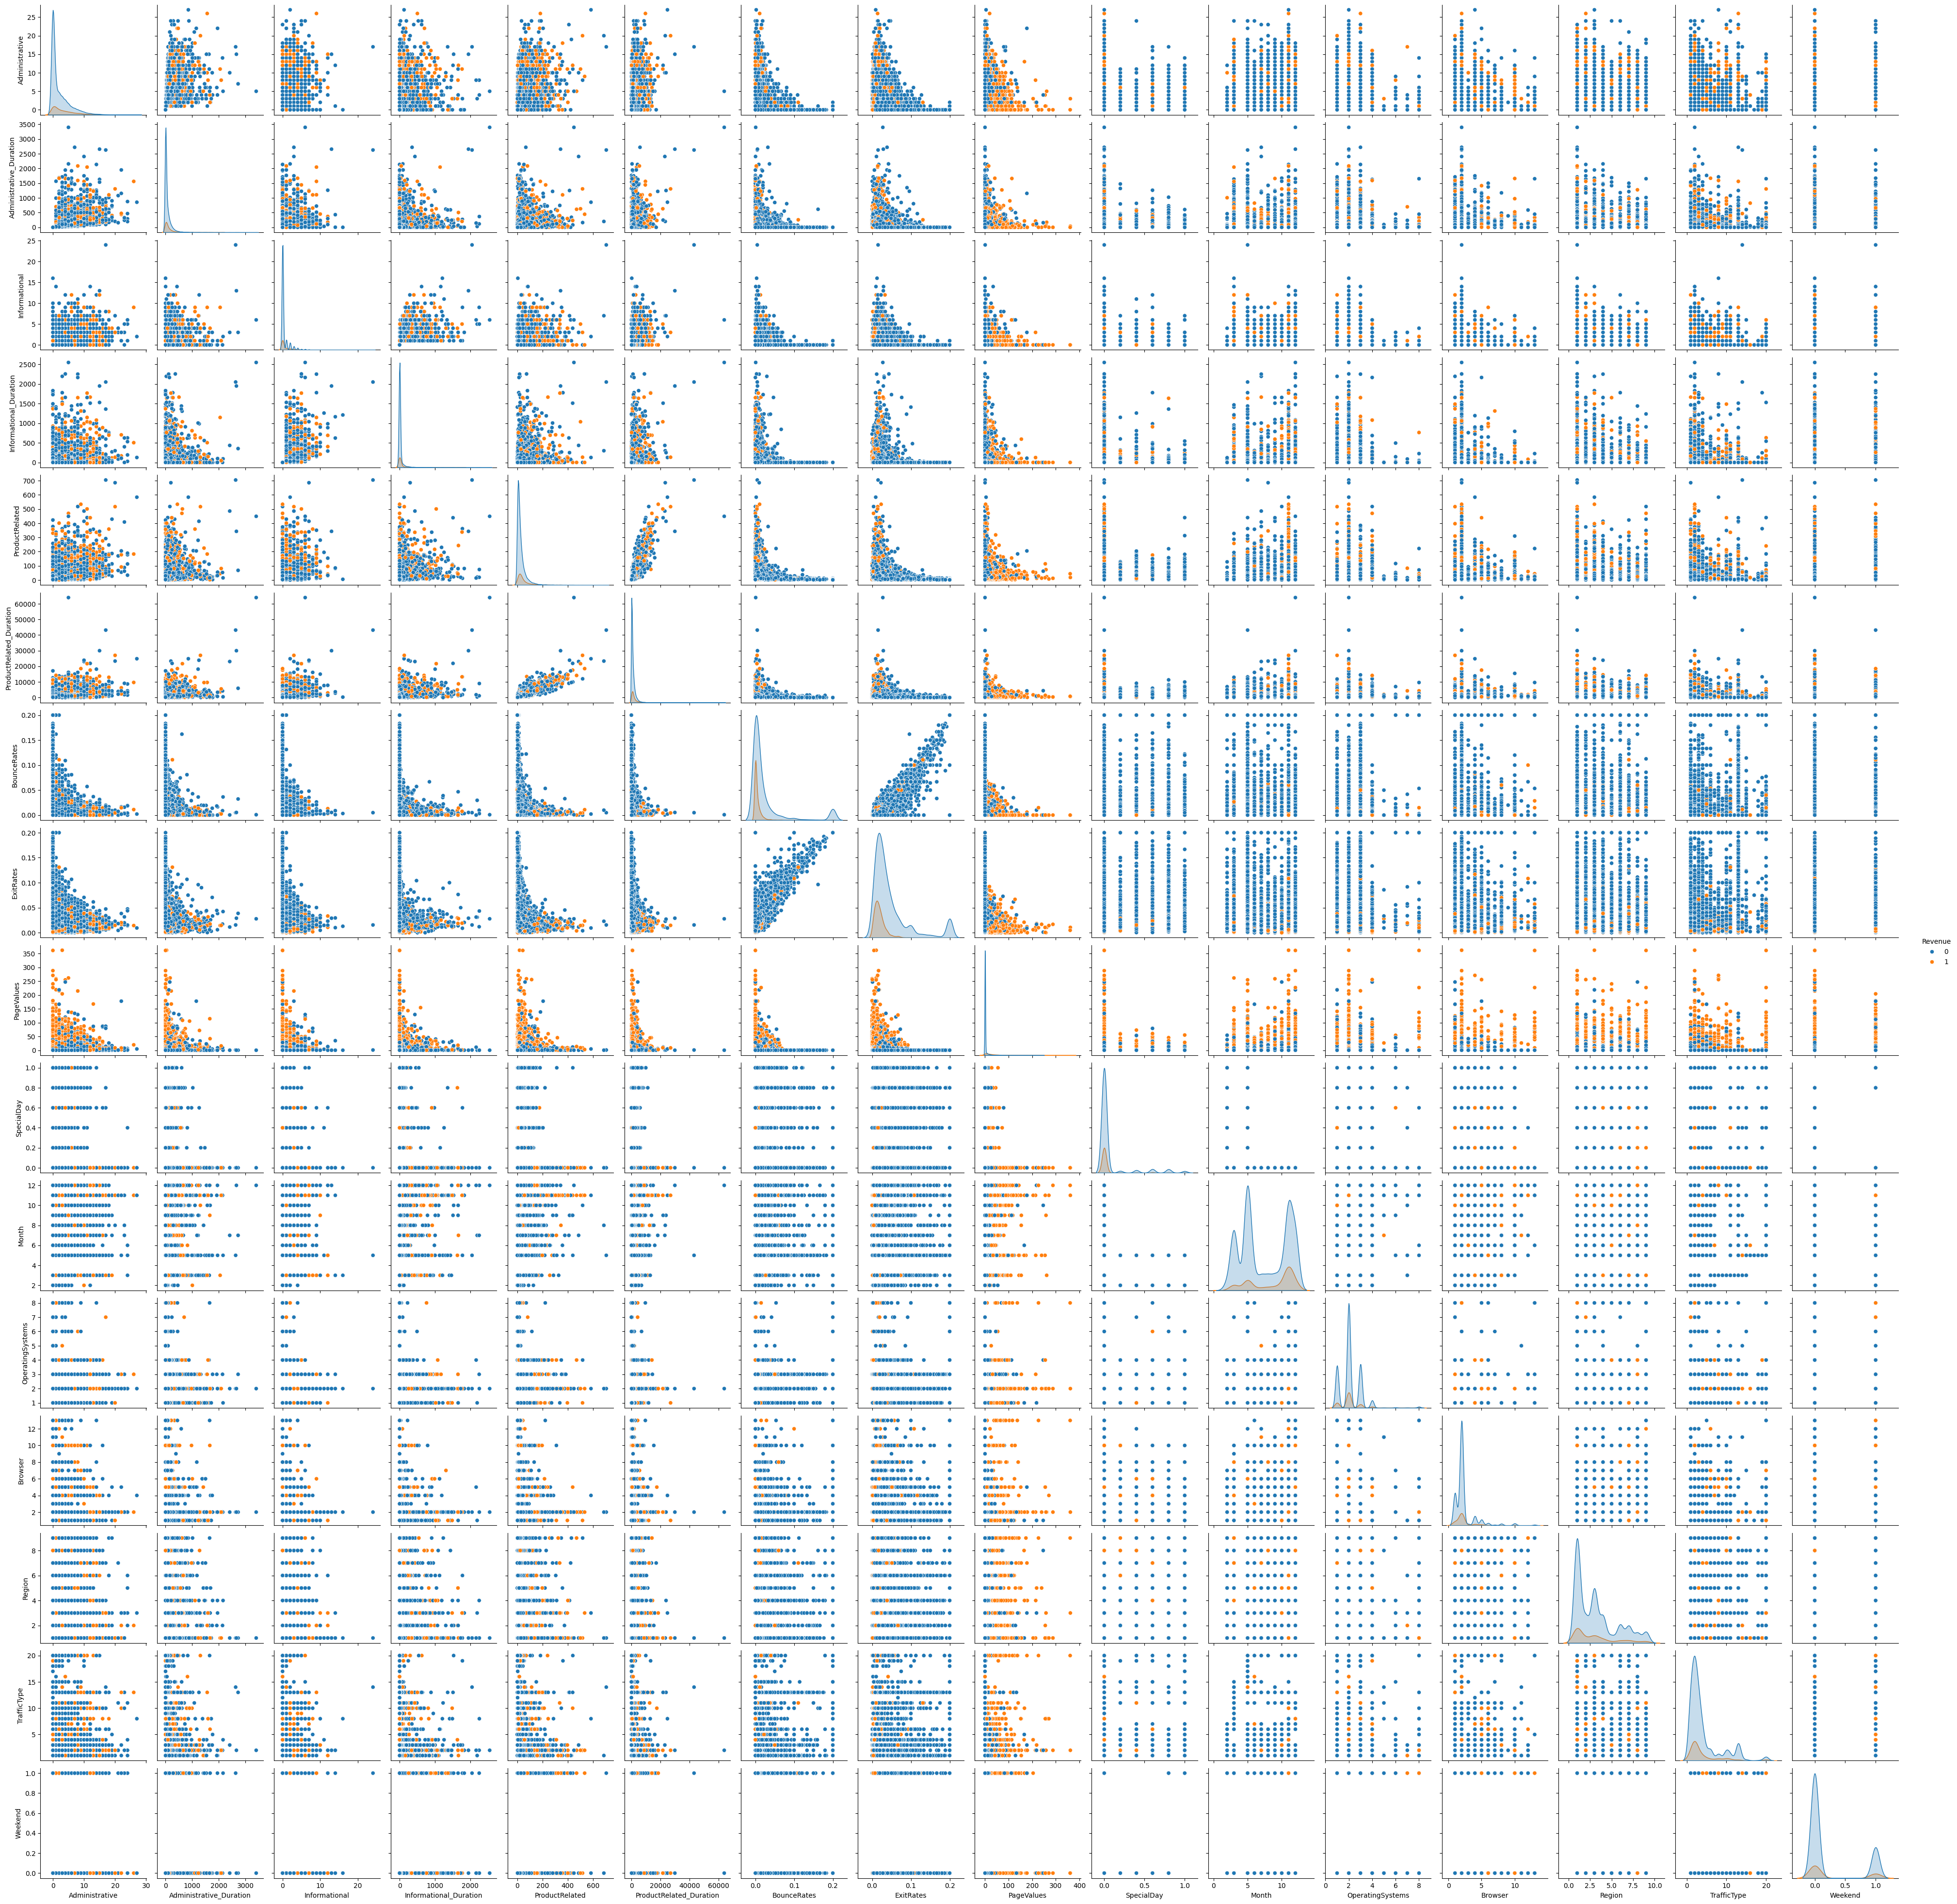

In [80]:


sns.pairplot(df_clean, hue="Revenue")


# ##### Analysis
# My eyes

# #### 1.3.4. Cleaning Data

In [81]:


# remove outliers with low frequencies
df_temp = df_clean.copy()
df_clean = df_clean[((df_clean['Administrative'] < 25) & 
                     (df_clean['Administrative_Duration'] < 2000) & 
                     (df_clean['Informational'] < 15) & 
                     (df_clean['Informational_Duration'] < 1750) & 
                     (df_clean['ProductRelated'] < 475) & 
                     (df_clean['ProductRelated_Duration'] < 30000) & 
                     (df_clean['BounceRates'] < 0.175) & 
                     (df_clean['ExitRates'] < 0.19) &
                     (df_clean['PageValues'] < 250))]

In [82]:


# verify removal
rows_remove = len(df_temp) - len(df_clean)
print(f"The numbers of rows removed: {rows_remove}")


# ## 2. Feature Engineering

The numbers of rows removed: 751


In [83]:


# since we do not have enough context to extract meaning from the values of categorical variables such as 'OperatingSystems', 'Browser', 'Region', and 'TrafficType', 
# we will drop these columns.
df_features = df.copy()
df_features = df_clean.drop(columns=["OperatingSystems", "Browser", "Region", "TrafficType"])

# apply one-hot encoding to 'VisitorType' and concatenate with the original DataFrame
df_features = pd.concat([df_features, pd.get_dummies(df_features["VisitorType"], prefix='VisitorType_')], axis=1)

# drop the original 'VisitorType' column
df_features.drop("VisitorType", axis=1, inplace=True)

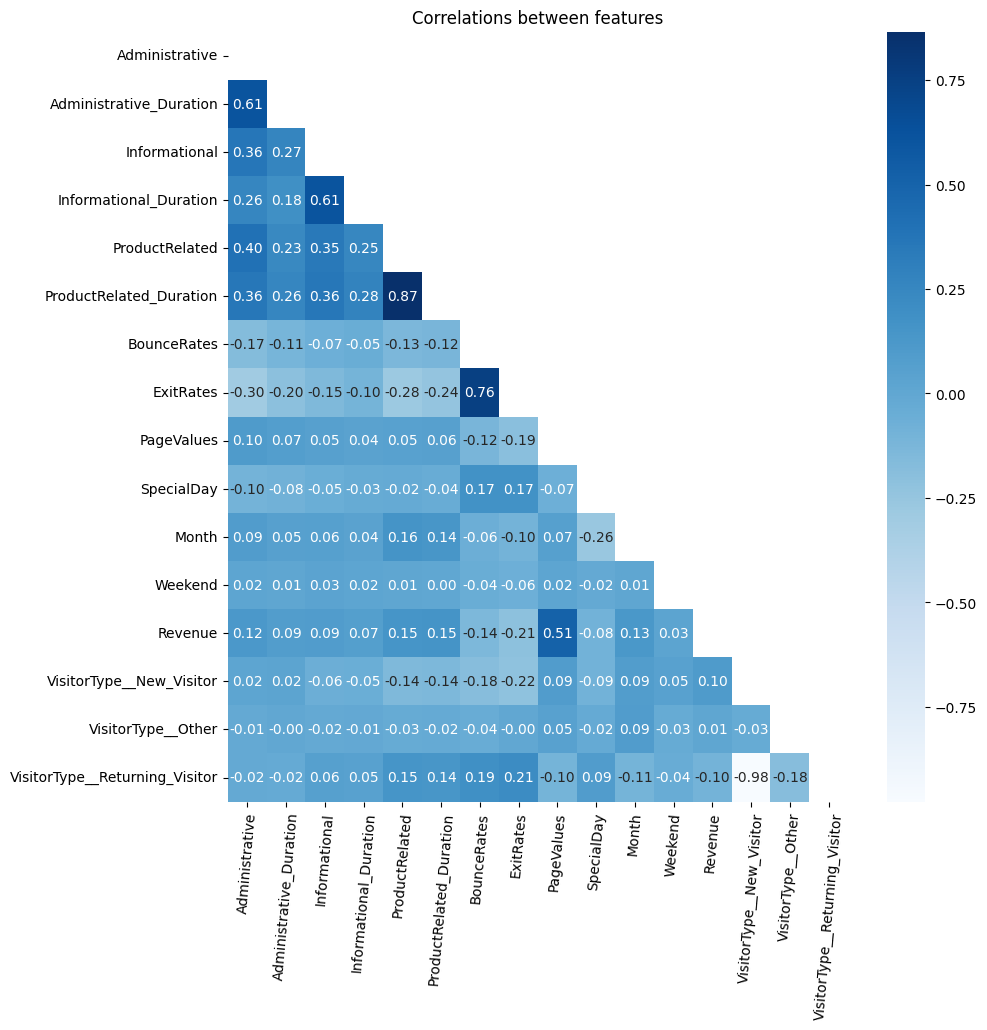

In [84]:


# correlation analysis
target_df = df_features['Revenue']

all_corr = df_features.corr(method = 'pearson')

mask = np.zeros_like(all_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

ax = plt.figure(figsize=(10, 10))
ax = sns.heatmap(all_corr, cmap='Blues', annot=True, fmt='.2f', mask = mask)
ax = plt.xticks(rotation=85)
ax = plt.title("Correlations between features")


# ##### Hypothesis
# 1. Regression
# 2. Clustering
# 3. Classification

# ## 3. Data Modelling

# ### 3.1. Regression

# ### 3.2. Clustering

# ### 3.3. Classification

In [85]:


X = df_features.drop(columns=['Revenue'])
Y = df_features['Revenue'].astype(int)


# ### Check the data imbalancing

In [86]:


value_counts = Y.value_counts()
print(value_counts)


# ### Oversample the imbalance data
# 

Revenue
0    9689
1    1890
Name: count, dtype: int64


In [87]:

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ros = RandomOverSampler()
X_KNN, Y_KNN = ros.fit_resample(X, Y) # take more from the less class to increase its size

In [88]:


value_counts = Y_KNN.value_counts()
print(value_counts)


# ## Spliting the data

Revenue
0    9689
1    9689
Name: count, dtype: int64


In [89]:


x_train, x_test, y_train, y_test = train_test_split(X_KNN, Y_KNN, test_size = 0.2, random_state = 0)

In [90]:
# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [91]:


param_dist = {
    'n_neighbors': randint(3, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [92]:


# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x748660ea9b20>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy', verbose=1)

In [93]:


# Get the best parameters and best estimator
best_params = random_search.best_params_
best_knn = random_search.best_estimator_

In [94]:


# Evaluate the best model
y_pred = best_knn.predict(x_test)

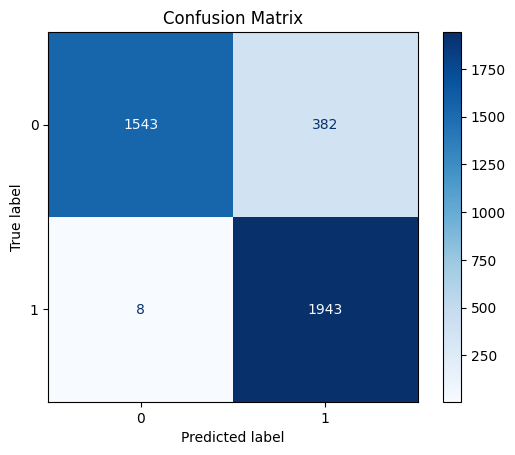

In [95]:


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [96]:


# Print the best parameters and evaluation metrics
print("Best Parameters:", best_params)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
Confusion Matrix:
[[1543  382]
 [   8 1943]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1925
           1       0.84      1.00      0.91      1951

    accuracy                           0.90      3876
   macro avg       0.92      0.90      0.90      3876
weighted avg       0.91      0.90      0.90      3876


Accuracy: 0.8993808049535603


In [97]:


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

In [98]:


X = df_features.drop('Revenue', axis=1)    
y = df_features['Revenue']

In [99]:


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [100]:


# Initializing the RandomForestClassifier
random_forest = RandomForestClassifier(random_state=42)

In [101]:


# Setting up the GridSearch to find the best parameters
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf = grid_search.best_estimator_

# Making predictions with the best model
y_pred = best_rf.predict(X_test)

# Generating the classification report
report = classification_report(y_test, y_pred)
print(report)





Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=10, min_s